In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
from model_fashion_mnist import Net, Net2c
from visualize import viz_filters, viz_ims
import dset_fashion_mnist as dset
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# set args
args = dset.get_args()
args.cuda = "True"
args.epochs = 100
args.lr = 0.001

# load fashion-mnist dataset
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# model
model = Net().to(device)
model.load_state_dict(torch.load('./fashion-mnist.model.pth', map_location=device))
model = model.eval().to(device)

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convt1 = nn.ConvTranspose2d(10, 1, kernel_size=6, stride=2, padding=0, bias=False)
        
    def forward(self, x):
        return self.convt1(x)
    

class Reconstruction(nn.Module):
    def __init__(self, model, generator):
        super(Reconstruction, self).__init__()
        self.conv1 = model.conv1
        self.pool1 = model.pool1
        self.relu1 = model.relu1
        self.convt1 = generator.convt1
        
    def feature_map(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        return x
        
        
    def forward(self, x):
        return self.convt1(self.feature_map(x))


In [27]:
# model
netG = Generator().to(device)

# prepend model and netG
netR = Reconstruction(model, netG).to(device)

# criterion
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

In [28]:
# Training Loop
# Lists to keep track of progress
G_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(args.epochs):
    # For each batch in the dataloader
    for i, (data, target) in enumerate(train_loader, 0):
        if args.cuda:
            data = data.to(device)
        data_ = netR(data)
        # loss
        loss = criterion(data, data_)
        # zero grad
        netG.zero_grad()
        # backward
        loss.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % args.log_interval == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                       100. * i / len(train_loader), loss.data.item()), end='')

        # Save Losses for plotting later
        G_losses.append(loss.item())


Starting Training Loop...
Train Epoch: 99 [59520/60000 (99%)]	Loss: 0.014689

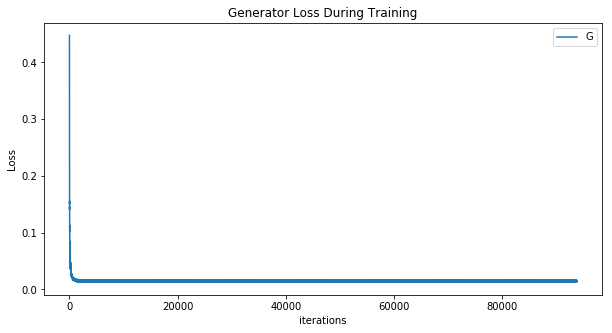

In [29]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses, label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

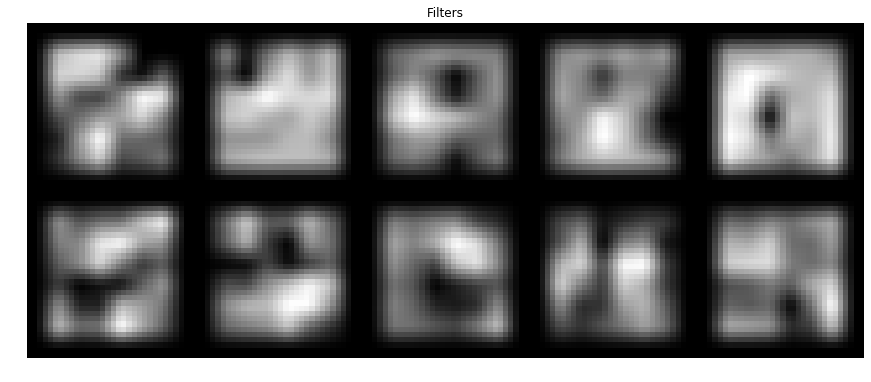

In [30]:
# viz filters
viz_filters(netG)

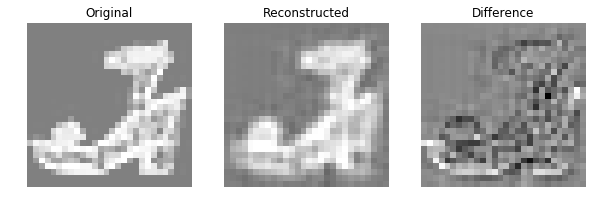

0.022824372538068197


In [31]:
num = 60
im = iter(train_loader).next()[0][num:num+1].to(device)
viz_ims(im, netR(im))
print(torch.norm(im - netR(im)).item()**2/28**2)